In [1]:
import keras
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
#from keras.applications.xception import Xception, preprocess_input, decode_predictions
#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.optimizers import Adam, RMSprop
#matplotlib inline

#import PIL
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D
import os
import glob
import numpy as np
from keras import backend as K
#from keras.engine.topology import Layer
from keras import optimizers 
from keras.optimizers import Adam, RMSprop
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Flatten





In [2]:
import os
import glob
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

data_path = "C:/Users/otunu/Convolutionary-Neural-Network/"
train_dir = data_path + "train/"
test_dir = data_path + 'valid/'

def predict_test(new_model, training_set):
    test_dirs = os.listdir(test_dir)
    correct = 0
    count = 0
    for f in test_dirs:
        if os.path.isdir(test_dir + f):
            img_path = glob.glob(test_dir + f + "/*.jpg")
            for i in range(0, len(img_path)):
                # Load the image
                img = image.load_img(img_path[i], target_size=(224, 224))
                conv_model = image.img_to_array(img)
                conv_model = np.expand_dims(conv_model, axis=0)
                conv_model = preprocess_input(conv_model)
                
                # Predict the class
                preds = new_model.predict(conv_model)
                ind = np.argmax(preds)
                
                # Check if the prediction is correct
                if ind == training_set.class_indices[f]:
                    correct += 1
                count += 1
                
    return float(correct) / float(count)


In [3]:
model = VGG19(weights='imagenet', include_top=False)

datagen_train = image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest')

datagen_test = image.ImageDataGenerator(rescale=1./255)
batch_size = 64

training_set = datagen_train.flow_from_directory(
        train_dir,
        target_size=(224, 224) ,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

#from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras import mixed_precision
# Set the policy to mixed_float16
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


Found 6348 images belonging to 11 classes.
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [4]:
test_set = datagen_test.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size= batch_size,
        shuffle=False,
        class_mode='categorical')

steps_test = test_set.n/batch_size
print(steps_test)

Found 1377 images belonging to 11 classes.
21.515625


In [5]:
x = model.layers[19].output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

x = Dropout(0.5)(x)

predictions = Dense(11, activation='softmax')(x)

new_model = Model(inputs= model.input, outputs=predictions)

optimizer = Adam(learning_rate=1e-4)

loss= 'categorical_crossentropy'
metrics=['categorical_accuracy']

def print_layer_trainable():
    for layer in new_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
print_layer_trainable()


for layer in model.layers:
    layer.trainable = False

print_layer_trainable()

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

new_model.summary()

steps_per_epoch =45

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving.
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=1e-7)

history =new_model.fit(
        x=training_set,
        steps_per_epoch=steps_per_epoch,
        epochs=50,
        validation_data=test_set,
        validation_steps=steps_test,
        callbacks=[lr_reduction] )


result = new_model.evaluate(test_set, steps=steps_test)

print("Test-set classification accuracy:{0:.2%}".format(result[1]))

results = new_model.evaluate(training_set, steps=steps_test)

print("Training-set classification accuracy:{0:.2%}".format(results[1]))



True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_conv4
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	global_average_pooling2d
True:	dense
True:	dropout
True:	dense_1
False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
True:	global_average_pooling2d
True:	dense
True:	dropout
True:	dense_1
Model: "model"
_________________________________________________________________
 Layer (type)  

Epoch 21/50
45/45 [==============================] - 1145s 26s/step - loss: 1.5780 - categorical_accuracy: 0.4689 - val_loss: 1.4844 - val_categorical_accuracy: 0.4829 - lr: 1.0000e-04
Epoch 22/50
45/45 [==============================] - 1140s 25s/step - loss: 1.5754 - categorical_accuracy: 0.4579 - val_loss: 1.4742 - val_categorical_accuracy: 0.4902 - lr: 1.0000e-04
Epoch 23/50
45/45 [==============================] - 1139s 25s/step - loss: 1.5542 - categorical_accuracy: 0.4742 - val_loss: 1.4848 - val_categorical_accuracy: 0.4880 - lr: 1.0000e-04
Epoch 24/50
45/45 [==============================] - 1150s 26s/step - loss: 1.5856 - categorical_accuracy: 0.4538 - val_loss: 1.4499 - val_categorical_accuracy: 0.5084 - lr: 1.0000e-04
Epoch 25/50
45/45 [==============================] - 1152s 26s/step - loss: 1.5388 - categorical_accuracy: 0.4785 - val_loss: 1.4527 - val_categorical_accuracy: 0.5033 - lr: 1.0000e-04
Epoch 26/50
45/45 [==============================] - 1143s 26s/step - loss:

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
acc_stage = predict_test(new_model,training_set)  
print(acc_stage)



In [6]:
new_model.trainable =True

for layer in new_model.layers:
    trainable = ('block5' in layer.name or 'block4' in layer.name or 'block3' in layer.name)
    
    layer.trainable = trainable
    
print_layer_trainable()

# Compile model with a scheduler
optimizer_fine= Adam(lr=1e-6)

new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)



False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_conv4
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
False:	global_average_pooling2d
False:	dense
False:	dropout
False:	dense_1


C:\Users\otunu\anaconda3\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:

history =new_model.fit(
        x=training_set,
        steps_per_epoch=steps_per_epoch,
        epochs=70,
        validation_data=test_set,
        validation_steps=steps_test,
        callbacks=[lr_reduction] )


result = new_model.evaluate(test_set, steps=steps_test)

print("Test-set classification accuracy:{0:.2%}".format(result[1]))
results = new_model.evaluate(training_set, steps=steps_test)

print("Training-set classification accuracy:{0:.2%}".format(results[1]))

#from sklearn.metrics import  precision_score

#precision_score(test_set,training_set) 



Epoch 1/70
45/45 [==============================] - 2428s 54s/step - loss: 1.3898 - categorical_accuracy: 0.5170 - val_loss: 1.2809 - val_categorical_accuracy: 0.5635 - lr: 1.0000e-06
Epoch 2/70
45/45 [==============================] - 2428s 54s/step - loss: 1.3511 - categorical_accuracy: 0.5288 - val_loss: 1.2636 - val_categorical_accuracy: 0.5701 - lr: 1.0000e-06
Epoch 3/70
45/45 [==============================] - 2392s 53s/step - loss: 1.3435 - categorical_accuracy: 0.5389 - val_loss: 1.2619 - val_categorical_accuracy: 0.5606 - lr: 1.0000e-06
Epoch 4/70
45/45 [==============================] - 2428s 54s/step - loss: 1.3062 - categorical_accuracy: 0.5472 - val_loss: 1.2235 - val_categorical_accuracy: 0.5752 - lr: 1.0000e-06
Epoch 5/70
45/45 [==============================] - 2385s 53s/step - loss: 1.3171 - categorical_accuracy: 0.5537 - val_loss: 1.2325 - val_categorical_accuracy: 0.5650 - lr: 1.0000e-06
Epoch 6/70
45/45 [==============================] - 2415s 54s/step - loss: 1.279

Epoch 44/70
45/45 [==============================] - 2290s 51s/step - loss: 1.0411 - categorical_accuracy: 0.6313 - val_loss: 1.0253 - val_categorical_accuracy: 0.6507 - lr: 2.5000e-07
Epoch 45/70
45/45 [==============================] - 2300s 51s/step - loss: 1.0714 - categorical_accuracy: 0.6333 - val_loss: 1.0017 - val_categorical_accuracy: 0.6601 - lr: 2.5000e-07
Epoch 46/70
45/45 [==============================] - 2349s 52s/step - loss: 1.0566 - categorical_accuracy: 0.6302 - val_loss: 1.0055 - val_categorical_accuracy: 0.6565 - lr: 2.5000e-07
Epoch 47/70
45/45 [==============================] - 2438s 54s/step - loss: 1.0396 - categorical_accuracy: 0.6479 - val_loss: 1.0064 - val_categorical_accuracy: 0.6565 - lr: 2.5000e-07
Epoch 48/70
45/45 [==============================] - ETA: 0s - loss: 1.0412 - categorical_accuracy: 0.6378 
Epoch 48: ReduceLROnPlateau reducing learning rate to 1.2499999968440534e-07.
45/45 [==============================] - 2428s 54s/step - loss: 1.0412 - c

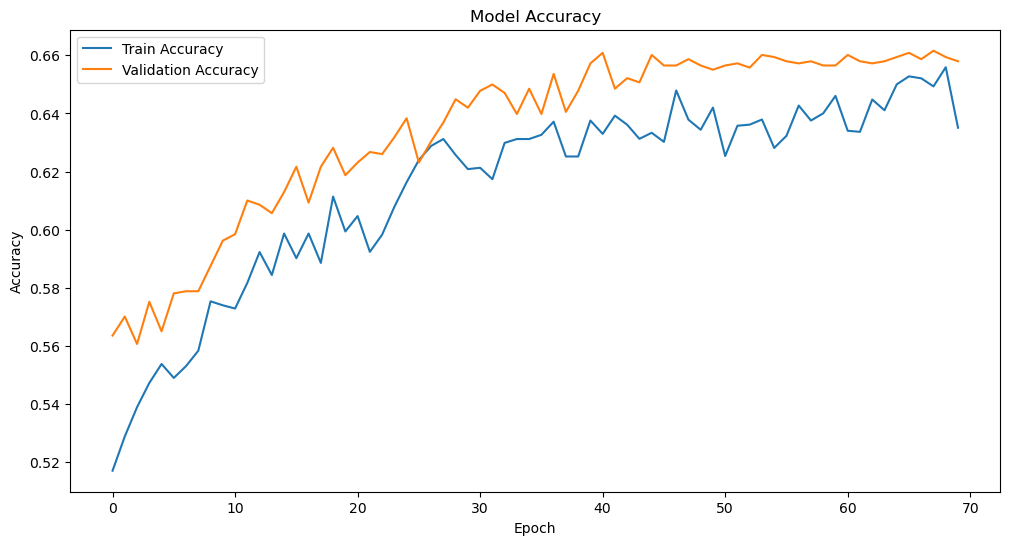

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()



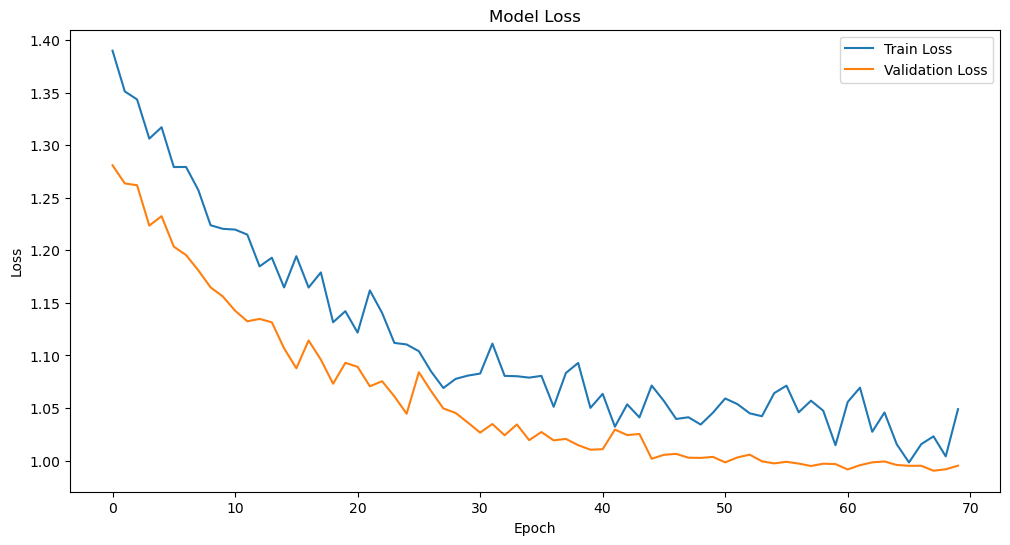

In [9]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [10]:
print("Test-set classification accuracy:{0:.2%}".format(result[1]))

Test-set classification accuracy:65.80%


In [11]:
print("Training-set classification accuracy:{0:.2%}".format(results[1]))


Training-set classification accuracy:66.55%


In [12]:
acc_stage1 = predict_test(new_model,training_set)  
print(acc_stage1)


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 442ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 467ms/step


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 462ms/step
0.29484386347131447
